In [9]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.io.wavfile import write
import sounddevice as sd
import matplotlib.pyplot as plt

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    return filtfilt(b, a, data)

def add_ramps(data, ramp_duration, fs):
    ramp_samples = int(ramp_duration * fs)
    ramp_up = np.linspace(0, 1, ramp_samples)
    ramp_down = np.linspace(1, 0, ramp_samples)
    data[:ramp_samples] *= ramp_up
    data[-ramp_samples:] *= ramp_down
    return data

def generate_sine_wave_noise(duration, fs, center_freq, width=1/3, ramp_duration=0.01):
    # Calculate lowcut and highcut for 1/3 octave
    factor = 2 ** (width / 2)
    lowcut = center_freq / factor
    highcut = center_freq * factor
    
    # Time axis
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    
    # Initialize noise
    noise = np.zeros_like(t)
    
    # Generate 2000 sine waves with random frequencies and phases within the band
    for _ in range(2000):
        freq = np.random.uniform(lowcut, highcut)
        phase = np.random.uniform(0, 2 * np.pi)
        sine_wave = np.sin(2 * np.pi * freq * t + phase)
        noise += sine_wave
    
    # Apply ramps before normalizing
    noise = add_ramps(noise, ramp_duration, fs)
    
    # Normalize the noise to have a peak-to-peak amplitude of -1 to 1 after applying ramps
    noise /= np.max(np.abs(noise))
    
    return noise


def generate_intervals(repetition_rate, jitter, duration, fs):
    mean_interval = 1 / repetition_rate
    intervals = np.abs(np.random.normal(mean_interval, jitter, int(duration / mean_interval)))
    return intervals

def plot_fft(data, fs, xmin=20, xmax=5000):  # Adjusted xmin to 20 Hz for logarithmic scale
    fft_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(fft_data), 1/fs)
    half_len = len(freqs) // 2  # Only plotting the positive frequencies

    # Filtering out the frequencies and FFT data for positive frequencies and within xmin and xmax
    valid_indices = np.where((freqs > 0) & (freqs <= xmax))
    valid_freqs = freqs[valid_indices][:half_len]
    valid_fft_data = np.abs(fft_data)[valid_indices][:half_len]

    plt.plot(valid_freqs, valid_fft_data)
    plt.title('FFT of the Noise Burst')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(xmin, xmax)
    plt.xscale('log')  # Set the x-axis to a logarithmic scale
    plt.show()


def create_sound_stream(center_freq, repetition_rate, jitter=0, duration=10, noise_duration=0.1, fs=44100, rhythmic=True):
    intervals = generate_intervals(repetition_rate, jitter, duration, fs) if not rhythmic else np.full(int(duration * repetition_rate), 1 / repetition_rate)
    
    sound_stream = np.array([])
    for interval in intervals:
        # Generate noise burst of specified duration
        noise = generate_sine_wave_noise(noise_duration, fs, center_freq, width=1/3, ramp_duration=0.005)
        # Add silence after the noise burst until the next interval starts
        silence_duration = int((interval - noise_duration) * fs) if interval > noise_duration else 0
        silence = np.zeros(silence_duration)
        sound_stream = np.concatenate((sound_stream, noise, silence))
    
    # Normalize to prevent clipping
    sound_stream = sound_stream / np.max(np.abs(sound_stream))
    
    return sound_stream





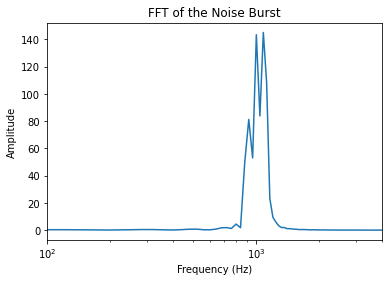

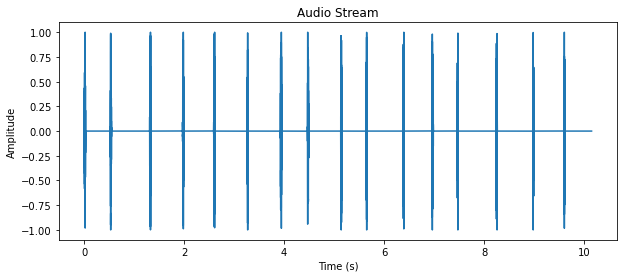

In [10]:
# Example usage
fs = 44100  # Sampling frequency
center_freq = 1000  # Center frequency of the noise
repetition_rate = 1.6  # Repetition rate in Hz
jitter = 0.1  # Standard deviation of the intervals in Sec., set to 0 for perfectly rhythmic. We used 0, 0.04,0.08,0.12. 
duration = 10  # Total duration of the sound stream in seconds
noise_duration = 0.025  # Duration of each noise burst in seconds

sound_stream = create_sound_stream(center_freq, repetition_rate, jitter, duration, noise_duration, fs, rhythmic=False)


# Play sound
sd.play(sound_stream, fs)
sd.wait()

# Save to file
write('output_sound.wav', fs, sound_stream.astype(np.float32))

# check spectrum of the noise
plot_fft(sound_stream[:int(fs*noise_duration)], fs,100,4000)

# check stream of noises
time = np.arange(0, len(sound_stream)) / fs

plt.figure(figsize=(10, 4))
plt.plot(time, sound_stream)
plt.title('Audio Stream')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


# Play sound
#sd.play(sound_stream, fs)
#sd.wait()